In [1]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, rerun_jtap_single_run, jtap_plot_lr_lines, red_green_viz_notebook, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_left_right_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import jtap_compute_beliefs, JTAPMice_Beliefs

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
LR_CONFIG= 'lr_v1'
LR_TRIAL = 1

stimulus_path = f'/home/arijitdasgupta/jtap-mice/notebooks/left_right_task/{LR_CONFIG}.json'

jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL)

rgb_video_highres = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY*5, skip_t = SKIP_T, rgb_only = True, trial_number = LR_TRIAL)

In [3]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [5]:
# Parameters based on default values in ChexModelInput @datastrucs.py

model_direction_flip_prob = 0.025
simulation_direction_flip_prob = 0.025
proposal_direction_flip_prob = 0.025

σ_pos_model=0.5
σ_pos_simulation=0.05
σ_pos_stepprop = 0.01

σ_speed_model=0.075
σ_speed_simulation=0.075
σ_speed_stepprop = 0.01

Model_Input = ChexModelInput(
    model_outlier_prob = 0.00,
    proposal_direction_outlier_tau = d2r(40.),
    proposal_direction_outlier_alpha = 3.5,
    σ_pos_model=σ_pos_model,
    σ_speed_model=σ_speed_model,
    model_direction_flip_prob=model_direction_flip_prob,
    pixel_corruption_prob=0.01,
    tile_size=3,
    σ_pixel_spatial=1.0,
    image_power_beta=0.005,
    max_speed=1.0,
    max_num_occ=5,
    num_x_grid=8,
    grid_size_bounds=(0.05, 0.95),
    simulate_every=1,
    σ_pos_simulation=σ_pos_simulation,
    σ_speed_simulation=σ_speed_simulation,
    simulation_direction_flip_prob=simulation_direction_flip_prob,
    σ_pos_initprop=0.02,
    proposal_direction_flip_prob=proposal_direction_flip_prob,#direction_flip_prob,
    σ_speed_stepprop=σ_speed_stepprop,
    σ_pos_stepprop=σ_pos_stepprop
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.0
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 30

In [10]:
num_jtap_runs = 50

start_time = time.time()
JTAPMICE_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAPMICE_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAPMICE_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 9.0% of 30 particles
Resampling occurred in 0.0% of 46 frames
Time taken for parallel JTAP: 0.11922240257263184 seconds


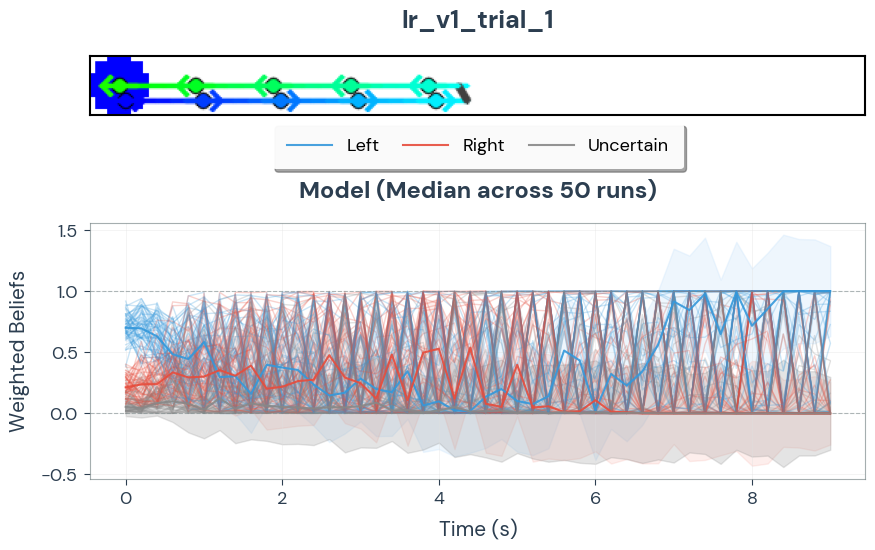

In [23]:
jtap_mice_beliefs = jtap_compute_beliefs(JTAPMICE_DATA)
jtap_run_idx = None
show_all_lines = True
show_std_band = True
jtap_plot_lr_lines(lr_beliefs = jtap_mice_beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=False, remove_legend=False, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import jax.numpy as jnp

from IPython.display import HTML

def compute_lr_beliefs_directly(jtap_inference, jtap_run_idx, pred_len, num_frames, num_particles):
    """
    Manually compute the marginals over left/right/uncertain for each frame and run,
    for the specific prediction step offset of interest.

    Returns:
        lr_belief_probs: (num_frames, 3) array of probabilities for [left, right, uncertain].
    """
    # Shapes: tracking/probabilities - (num_runs, num_frames, ...), e.g., (50, 46, ...)
    # We need prediction.lr: (num_runs, num_frames, pred_len, num_particles)
    # And inf.weight_data.final_weights: (num_runs, num_frames, num_particles)
    pred_lr = jtap_inference.prediction.lr
    weights = jtap_inference.weight_data.final_weights

    # Select run dimension if necessary
    arr_idx = jtap_run_idx if pred_lr.shape[0] > 1 else 0

    # Pick out predicted LR values at the prediction_t_offset-1 frame
    pred_lr = pred_lr[arr_idx]  # shape: (num_frames, pred_len, num_particles)
    w = weights[arr_idx]        # shape: (num_frames, num_particles)

    # Select the timestep offset for belief
    offset = pred_len if pred_len is not None else jtap_inference.prediction.x.shape[1]
    idx = min(offset, pred_lr.shape[1]) - 1

    # Get for each t particle the lr hit at the specified prediction time
    # coded_lr_hits: (num_frames, num_particles)
    coded_lr_hits = np.array(pred_lr[:, idx, :])  # Ensure np.ndarray

    # Normalize weights for each timepoint
    # w: (num_frames, num_particles)
    w = np.array(w)  # Ensure np.ndarray
    normalized_probs = np.exp(w - np.max(w, axis=1, keepdims=True))
    normalized_probs = normalized_probs / np.sum(normalized_probs, axis=1, keepdims=True)

    # Calculate for left/right/uncertain:
    left_probs = np.sum((coded_lr_hits == 0) * normalized_probs, axis=1)
    right_probs = np.sum((coded_lr_hits == 1) * normalized_probs, axis=1)
    uncertain_probs = np.sum((coded_lr_hits == 2) * normalized_probs, axis=1)
    lr_belief_probs = np.stack([left_probs, right_probs, uncertain_probs], axis=1)
    return lr_belief_probs

def animate_jtap_predictions(JTAPMICE_DATA, pred_len=None, jtap_run_idx=0, image_scale=4, max_particles_to_show=None, stimulus=None):
    """
    Visualize particles, predictions, and left/right beliefs as an animated matplotlib figure.

    Args:
        JTAPMICE_DATA: JTAPMiceData returned by inference.
        stimulus: Provide the stim object to extract RGB frames (else try from JTAPMICE_DATA.stimulus).
        pred_len: How many steps ahead to show predictions (default: all available steps).
        jtap_run_idx: Which JTAP run to visualize (if multiple are present).
        image_scale: How big to render image.
        max_particles_to_show: Optionally subsample number of particles for plotting efficiency.

    Returns:
        HTML-compatible animation object ready for Jupyter display.
    """
    # == 1. Extract essentials ==
    def _squeeze(arr):
        arr = np.array(arr)
        return arr[jtap_run_idx] if arr.shape[0] > 1 else arr[0]
    inf = JTAPMICE_DATA.inference

    # For predictions: shape (num_runs, num_frames, pred_len, num_particles)
    tracking_x = np.array(_squeeze(inf.tracking.x))  # (T, Np)
    tracking_y = np.array(_squeeze(inf.tracking.y)) if hasattr(inf.tracking, "y") else None # (T, Np)
    weights = np.array(_squeeze(inf.weight_data.final_weights))
    prediction_x = np.array(_squeeze(inf.prediction.x))  # (T, pred_len, Np)
    prediction_y = np.array(_squeeze(inf.prediction.y)) if hasattr(inf.prediction, "y") else None
    prediction_lr = np.array(_squeeze(inf.prediction.lr))  # (T, pred_len, Np), int-codes

    num_frames, num_particles = tracking_x.shape
    pred_steps = prediction_x.shape[1]
    plot_pred_steps = pred_len if (pred_len is not None and pred_len <= pred_steps) else pred_steps

    lr_belief_probs = compute_lr_beliefs_directly(
        JTAPMICE_DATA.inference,
        jtap_run_idx,
        plot_pred_steps,
        num_frames,
        num_particles
    )

    # Optionally subsample particles for plotting
    if (max_particles_to_show is not None) and (num_particles > max_particles_to_show):
        sample_idx = np.argsort(weights[0])[::-1][:max_particles_to_show]
    else:
        sample_idx = np.arange(num_particles)

    # == Extract stimulus frames ==
    if stimulus is None:
        if hasattr(JTAPMICE_DATA, "stimulus"):
            stimulus = JTAPMICE_DATA.stimulus
        else:
            raise ValueError("Must provide the stimulus or ensure JTAPMICE_DATA.stimulus exists")
    if hasattr(stimulus, "rgb_video_highres"):
        rgb_vid = np.asarray(stimulus.rgb_video_highres)
    elif hasattr(stimulus, "rgb_video"):
        rgb_vid = np.asarray(stimulus.rgb_video)
    elif hasattr(stimulus, "discrete_obs"):
        rgb_vid = discrete_obs_to_rgb(stimulus.discrete_obs)
    else:
        raise ValueError("Could not find rgb frames in stimulus.")
    H, W = rgb_vid.shape[1:3]
    n_time = rgb_vid.shape[0]

    # Ball diameter for X-center calculation - from stimuli.py
    diameter = getattr(stimulus, "diameter")
    ball_radius_scene = diameter / 2.0

    # == Matplotlib figure setup ==
    plt.rcParams.update({
        "font.size": 22,
        "axes.titlesize": 28,
        "axes.labelsize": 24,
        "xtick.labelsize": 22,
        "ytick.labelsize": 22,
        "legend.fontsize": 20,
    })

    fig = plt.figure(figsize=(image_scale * 7, image_scale * 4))
    gs = fig.add_gridspec(3, 4, height_ratios=[2, 2.5, 2], width_ratios=[4, 1, 0.01, 0.1])
    ax_pred = fig.add_subplot(gs[0:2, 0])  # prediction (top left, takes 2 rows)
    ax_belief = fig.add_subplot(gs[0:2, 1])  # LR bar (top right)
    ax_scene = fig.add_subplot(gs[2, 0])    # Scene/image (bottom left)

    ax_pred.set_title("Future Predicted Positions per Particle")
    ax_scene.set_title("Ball position (colored by weight) over RGB image")
    ax_belief.set_title("LR Belief (prob)")

    plt.tight_layout()

    # == Plotting primitives to be updated ==
    import matplotlib.patches as mpatches

    # Points for tracking/scene, black dots sized by weights
    scn_dots = ax_scene.scatter(
        [], [], s=[], c='black', alpha=1,
        edgecolors='white', linewidths=0.8, zorder=3
    )

    # Make sure rgb_vid overlays exactly at border at (0,0), origin upper, with full extent for pixel alignment fix
    img_artist = ax_scene.imshow(
        np.zeros_like(rgb_vid[0]), origin="upper", animated=True, zorder=0, extent=(0, W, H, 0)
    )

    # Add obs border rectangle box to ax_scene (will always be there, so can add now)
    obs_border_rect = mpatches.Rectangle(
        (0, 0), W, H,
        linewidth=4, edgecolor='black', facecolor='none', zorder=2
    )
    ax_scene.add_patch(obs_border_rect)

    lines = []
    for _ in sample_idx:
        # Use same alpha for all, but thickness variable
        line, = ax_pred.plot([], [], lw=3, color='yellow', alpha=0.85, zorder=2)
        lines.append(line)
    # Black dots at T=0 ("step 0") at different X's, sized by weights
    pred_dots = ax_pred.scatter([], [], s=[], c='black', alpha=1.0, zorder=3, edgecolors='white', linewidths=0.9)

    bar_beliefs = ax_belief.bar(['Left', 'Right', 'Unc.'], [0, 0, 0], color=['#3399FF', '#FF9933', '#C0C0C0'])

    # == Axes adjustments ==
    ax_pred.set_xlabel('X pos')
    ax_pred.set_ylabel('Prediction step (future)')

    # -- Full scene width on x --
    scene_dim = JTAPMICE_DATA.params.inference_input.scene_dim
    scene_dim = np.array(scene_dim)
    if scene_dim.size > 0:
        Wscene = float(np.ravel(scene_dim)[0])
    else:
        Wscene = 1.0
    ax_pred.set_xlim(0, Wscene)

    # 1. Y axis: flip so t=0 is at the bottom, preds go up (no invert_yaxis)
    ax_pred.set_ylim(-0.5, plot_pred_steps - 0.5)

    # 4. X-ticks at every integer position for the 2D plot
    # (if scene width < 20, integer ticks for the width, else use a reasonable number)
    if Wscene < 20:
        xticks = np.arange(0, int(np.ceil(Wscene)) + 1, 1)
        ax_pred.set_xticks(xticks)
    else:
        ax_pred.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Y-ticks for each prediction future step
    ax_pred.set_yticks(np.arange(0, plot_pred_steps, 1))
    ax_pred.set_yticklabels([f"+{yy}" for yy in range(plot_pred_steps)])

    ax_pred.grid(True, linestyle='--', alpha=0.3)

    # Fix for image/top border alignment
    ax_scene.set_axis_off()
    ax_scene.set_xlim(0, W)
    ax_scene.set_ylim(H, 0)
    ax_belief.set_ylim(0, 1.01)
    ax_belief.set_ylabel('Prob')
    ax_belief.set_xticks([0, 1, 2])
    ax_belief.set_xticklabels(['Left', 'Right', 'Unc.'])
    for spine in ["top", "right"]:
        ax_belief.spines[spine].set_visible(False)

    def normalize_weights(w):
        w = np.array(w)
        m = np.max(w)
        if m == 0:
            return np.ones_like(w)
        w = w - np.max(w)
        w = np.exp(w)
        return w / np.sum(w)

    def compute_dot_sizes(weights, min_size=10, max_size=190):
        wnorm = normalize_weights(weights)
        sizes = min_size + (max_size - min_size) * wnorm
        return sizes

    # == Animation function ==
    def animate(t):
        print(f"Animating frame {t + 1}/{num_frames}")
        img = rgb_vid[t]
        img_artist.set_data(img)
        img_artist.set_extent((0, W, H, 0))  # Always tightly align the image border

        tx = tracking_x[t]
        tw = weights[t]
        s_idx = np.array(sample_idx)
        tx_samp = np.array(tx[s_idx])
        tw_samp = np.array(tw[s_idx])

        scene_dim_anim = JTAPMICE_DATA.params.inference_input.scene_dim
        scene_dim_anim = np.array(scene_dim_anim)
        if scene_dim_anim.size > 0:
            Wscene = float(np.ravel(scene_dim_anim)[0])
        else:
            Wscene = 1.0

        # X-centering: correct from left-edge to center by +radius_in_scene
        tx_samp_center = tx_samp + ball_radius_scene

        # Map [0,Wscene] to [0,W] for pixel axis (as in obs image)
        x_pix_center = tx_samp_center * (W / Wscene)
        y_pix = np.ones_like(x_pix_center) * (H / 2)

        sizes_scn = compute_dot_sizes(tw_samp, min_size=32, max_size=210)
        scn_dots.set_offsets(np.stack([x_pix_center, y_pix], axis=1))
        scn_dots.set_sizes(sizes_scn)
        # Color is fixed black, with white edge

        # Update prediction dots in 2D plot (t=0 row, y=0)
        pred_x_samp = tx_samp_center
        pred_ys = np.zeros_like(s_idx)  # y=0 for t=0
        sizes_pred = compute_dot_sizes(tw_samp, min_size=25, max_size=120)
        pred_dots.set_offsets(np.stack([pred_x_samp, pred_ys], axis=1))
        pred_dots.set_sizes(sizes_pred)

        # Update prediction lines (future states) for each particle, center-aligned X
        for li, p_idx in enumerate(s_idx):
            xs = prediction_x[t, :plot_pred_steps, p_idx] + ball_radius_scene
            # For Y, now: Y-value is prediction step future (0, 1, 2...)
            this_ys = np.arange(0, plot_pred_steps)
            # only mask up to first hit
            lrs = prediction_lr[t, :plot_pred_steps, p_idx]
            mask = np.ones_like(lrs, dtype=bool)
            hits = np.where((lrs == 0) | (lrs == 1))[0]
            if len(hits) > 0:
                hit_idx = hits[0]
                mask[(hit_idx + 1):] = False
            this_xs = xs[mask]
            this_ys = this_ys[mask]
            lines[li].set_data(this_xs, this_ys)
            # All lines same alpha, thickness only by weight
            this_w = float(normalize_weights(weights[t])[p_idx])
            lines[li].set_linewidth(2.7 + 7.8 * this_w)
            lines[li].set_alpha(0.88)

        left_p, right_p, unc_p = lr_belief_probs[t]
        for i, bar in enumerate(bar_beliefs):
            bar.set_height([left_p, right_p, unc_p][i])
            if i == 0:
                bar.set_color("#0055CC" if left_p > right_p else "#3399FF")
            elif i == 1:
                bar.set_color("#FFA416" if right_p > left_p else "#FF9933")
            else:
                bar.set_color("#C0C0C0")
        ax_belief.set_ylim(0, 1.01)
        ax_belief.set_title("LR belief:\nL={:.2f}, R={:.2f}, U={:.2f}".format(left_p, right_p, unc_p), fontsize=26)
        for ax in [ax_pred, ax_scene]:
            ax.set_title(ax.get_title().split('\n')[0] + f"\nframe {t + 1}/{num_frames}", fontsize=26)
        return [img_artist, scn_dots] + lines + [pred_dots] + list(bar_beliefs) + [obs_border_rect]

    anim = animation.FuncAnimation(
        fig, animate, frames=num_frames, interval=100, blit=True, repeat=True
    )

    plt.close(fig)
    return HTML(anim.to_html5_video())

animate_jtap_predictions(JTAPMICE_DATA, jtap_run_idx=0)

In [ ]:
jtap_run_idx_viz = 9

rerun_jtap_single_run(JTAPMICE_DATA, rgb_video_highres = None, stimulus_name = "jtap_single_runv3", tracking_dot_size_range = (0.5,2), prediction_line_size_range = (0.05,0.4), jtap_run_idx = jtap_run_idx_viz, grid_dot_radius = 0.3, render_grid = True, show_velocity = True)

In [ ]:
slice_pt(JTAPMICE_DATA.step_prop_retvals,1)

In [ ]:
slice_pt(JTAPMICE_DATA.inference,1).prediction

In [ ]:
slice_pt(JTAPMICE_DATA.inference,1).prediction.x[...,3]

In [ ]:
key = jax.random.PRNGKey(np.random.randint(0, 1000000))
genjax.truncated_normal.sample(key, jnp.array([1.5]), jnp.array([100.0]), jnp.array([0.0]), jnp.array([1.0]))